In [1]:
import pandas as pnd
from Bio import Phylo
import gempipe

# evaluate filtering metrics

Removed after 'N50'>=19000: 217 / 980 strains
Removed after 'ncontigs%'<=240: 179 / 980 strains
Removed after 'BUSCO_M%'<=3: 356 / 980 strains
Removed after 'BUSCO_F%'<=2: 169 / 980 strains
Remaining: 545 / 980 strains


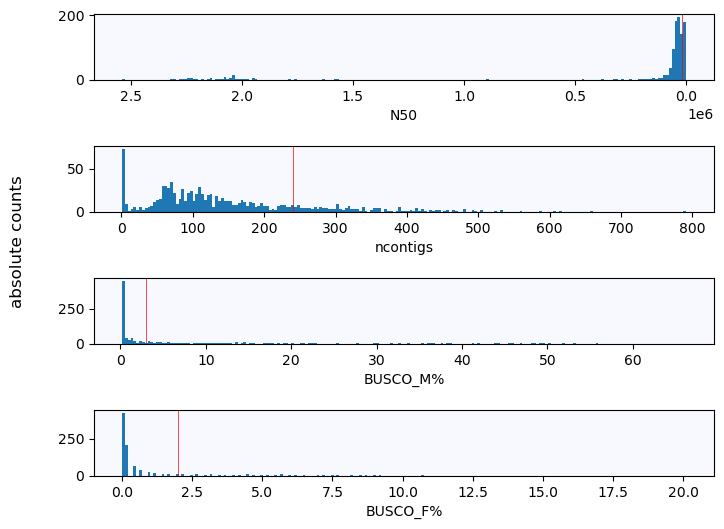

In [2]:
# threshold were selected to pickup all the type strains. 

summary_table, summary_table_filt, fig = gempipe.get_filtering_summary(
    working_dir='gempipe/working/',
    thr_N50=19000, thr_nc=240, thr_bm=3, thr_bf=2)

# update ANI matrices

In [3]:
# prune the newick tree

tree_original = Phylo.read('fastani/ANIclustermap_dendrogram.nwk', "newick")
for leaf in tree_original.get_terminals():
    acc = '_'.join(leaf.name.split('_', 2)[:2]) 
    if acc not in summary_table_filt.index:
        tree_original.prune(leaf)
    else: leaf.name = acc
_ = Phylo.write(tree_original, 'fastani/ANIclustermap_dendrogram_filt.nwk', 'newick')


In [4]:
# prune the triangular matrix

triangular = pnd.read_csv('fastani/ANIclustermap_matrix.tsv', sep='\t')
triangular.columns = ['_'.join(c.split('_', 2)[:2]) for c in triangular.columns]
triangular.index = triangular.columns
ord_leaves = [leaf.name for leaf in tree_original.get_terminals()]
triangular = triangular.loc[   # subset but maintain the same order
    [i for i in triangular.index if i in ord_leaves], 
    [c for c in triangular.columns if c in ord_leaves]]
triangular.to_csv('fastani/ANIclustermap_matrix_filt.tsv', sep='\t', index=False)


# assign subspecies metadata

According to Li2021 (10.1099/ijsem.0.004644).


In [5]:

# define strain_isolate label:

metadata = pnd.read_csv('genomes_all/raw_ncbi_1598.txt', sep='\t', index_col=0)
metadata = metadata.iloc[[i for i in range(len(metadata)) if i%2==0], ]  # remove report lines
metadata['infraspecific_name'] = metadata['infraspecific_name'].str.replace('strain=', '') 
metadata['infraspecific_name'] = metadata['infraspecific_name'].str.replace('na', '') 
metadata['isolate'] = metadata['isolate'].str.replace('na', '')
metadata['strain_isolate'] = metadata['infraspecific_name'] + metadata['isolate']


In [6]:
# update report table:

report = pnd.read_csv('gempipe/output_recon/report.csv', index_col=0)
report['niche'] = 'other_Lr'
report['species'] = 'other_Lr'

type_strains = {
    'Lr_kinnaridis': 'GCA_020786015.1', # AP3T
    'Lr_reuteri': 'GCA_000016825.1', # DSM 20016T   
    'Lr_rodentium': 'GCA_000168255.1', # 100-23T    
    'Lr_suis': 'GCA_000236455.2', # ATCC 53608T      
    'Lr_porcinus': 'GCA_036621895.1', # 3c6T  
    'Lr_murium': 'GCA_000179455.1', # lpuph1T  
}
Li2021_ani = {
    'Lr_kinnaridis': 98.2,
    'Lr_reuteri': 98.1,
    'Lr_rodentium': 96.1,
    'Lr_suis': 98.7,
    'Lr_porcinus': 99.1,   
    'Lr_murium': 96.8,
}  # porcinus has 2 strains (3c6T and 20-2)

for index, row in report.iterrows(): 
    report.loc[index, 'strain'] = metadata.loc[row['accession'], 'strain_isolate']
    
    
    # assign subspecies based on Li2021 ANI thresholds (in the 'species' field): 
    for subspecies, acc in type_strains.items(): 
        if row['accession'] in list(triangular[triangular[acc] >= Li2021_ani[subspecies]].index):
            if report.loc[index, 'species'] == 'other_Lr': 
                report.loc[index, 'species'] = subspecies
            else:  # ignore accessions assigned to 2+ subspecies
                report.loc[index, 'species'] = '-' 
    
    
    # assign subspecies based on a 97% ANI threshold (in the 'niche' field): 
    for subspecies, acc in type_strains.items(): 
        if row['accession'] in list(triangular[triangular[acc] >= 97].index):
            if report.loc[index, 'niche'] == 'other_Lr': 
                report.loc[index, 'niche'] = subspecies
            else:  # ignore accessions assigned to 2+ subspecies
                report.loc[index, 'niche'] = '-' 
        

print("strains assigned to 2+ spubspecies ('niche'):", len(report[report['niche']=='-']))   
print("strains assigned to 2+ spubspecies ('species'):", len(report[report['species']=='-']))

# replace '-', as it would be seen as another subspecies
report.loc[report['niche']=='-', 'niche'] = 'other_Lr'
report.loc[report['species']=='-', 'species'] = 'other_Lr'

report.to_csv('gempipe/report_updated.csv')
report

strains assigned to 2+ spubspecies ('niche'): 0
strains assigned to 2+ spubspecies ('species'): 62


,accession,species,strain,niche
0,GCA_002253725.1,other_Lr,601g,other_Lr
1,GCA_025963005.1,other_Lr,NPLps01.et-05,Lr_kinnaridis
2,GCA_022509245.1,Lr_murium,QAULRN18,Lr_murium
3,GCA_046937845.1,other_Lr,M978A,Lr_suis
4,GCA_002128585.1,Lr_suis,KLR2003,Lr_suis
...,...,...,...,...
540,GCA_036431085.1,other_Lr,FI11589,Lr_reuteri
541,GCA_948982165.1,Lr_rodentium,MGBC103889,other_Lr
542,GCA_020784305.1,Lr_rodentium,M_20,other_Lr
543,GCA_046938365.1,other_Lr,M758A,Lr_suis


In [7]:
report['species'].value_counts()

species
other_Lr         237
Lr_murium        116
Lr_kinnaridis     68
Lr_reuteri        63
Lr_rodentium      38
Lr_suis           21
Lr_porcinus        2
Name: count, dtype: int64

# plot updated ANI with subspecies

Leaves accessions not found in 'genomes': []


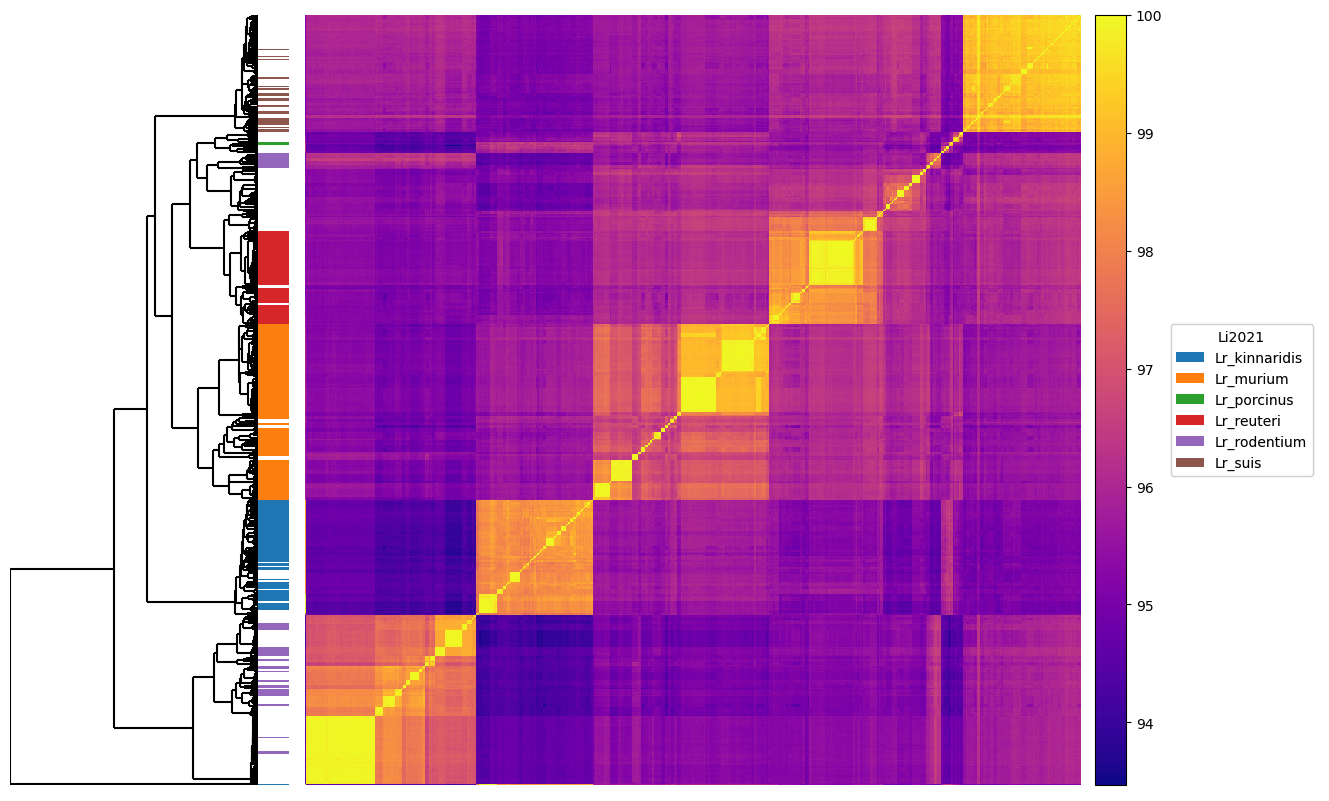

In [7]:
fig, triangular = gempipe.animatrix(
    tree_original='fastani/ANIclustermap_dendrogram_filt.nwk', 
    triangular='fastani/ANIclustermap_matrix_filt.tsv',
    verbose=True, replace0=0, cellannot=False, fastmode=True, legend_title='Li2021',
    genomes=report, niche=True, colorannot='species', nichewidth=0, excludeniche=['other_Lr'],
)

Leaves accessions not found in 'genomes': []


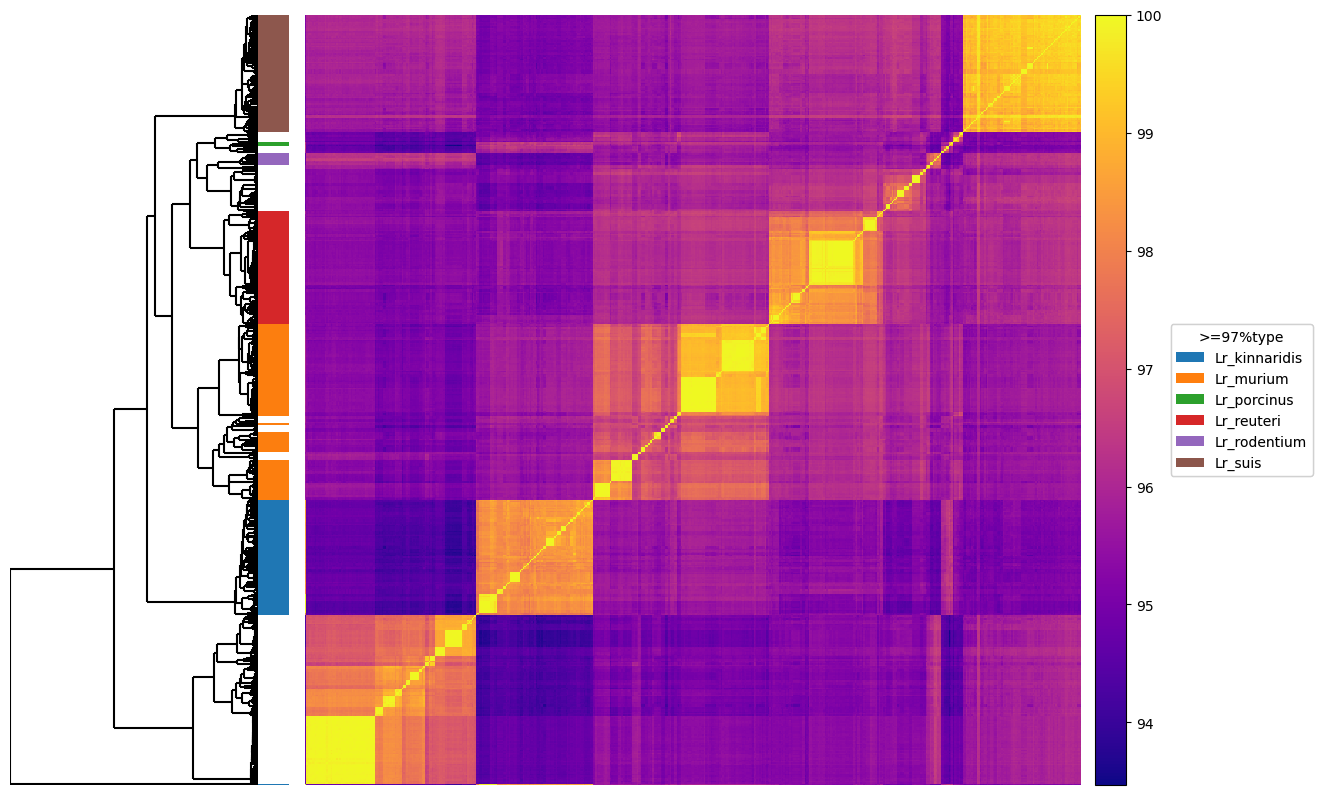

In [13]:
fig, triangular = gempipe.animatrix(
    tree_original='fastani/ANIclustermap_dendrogram_filt.nwk', 
    triangular='fastani/ANIclustermap_matrix_filt.tsv',
    verbose=True, replace0=0, cellannot=False, fastmode=True, legend_title='>=97%type',
    genomes=report, niche=True, colorannot='niche', nichewidth=0, excludeniche=['other_Lr']
)